# problem: my PTB WSJ corpus has no .raw files

## TODO: convert .mrg files to .raw

- some PTB WSJ .raw files are available here for comparison: https://github.com/teropa/nlp/tree/master/resources/corpora/treebank/raw

In [9]:
import glob
import os
import re
import sys

import nltk
import discoursegraphs as dg

In [3]:
raw_filepaths = sorted([f for f in dg.find_files('/home/arne/repos/nishida-nakayama/nlp/resources/corpora/treebank/raw')])
mrg_filepaths = sorted([f for f in dg.find_files('/home/arne/corpora/pennTreebank/parsed/mrg/wsj', '*.mrg')])

In [4]:
def filepath2id(filepath):
    basename = os.path.basename(filepath)
    match = re.search('\d+', basename)
    if match:
        return match.group()
    sys.stderr.write("Can't extract ID from filename: {}".format(basename))

id2mrg = {}
for mf in mrg_filepaths:
    id2mrg[filepath2id(mf)] = mf

Can't extract ID from filename: wsj.all.mrg

In [5]:
for rf in raw_filepaths:
    doc_id = filepath2id(rf)
    mrg_filepath = id2mrg.get(doc_id)
    if not mrg_filepath:
        print("NO MATCH for", os.path.basename(rf))

In [80]:
fpath = mrg_filepaths[0]
with open(fpath) as mrgf:
    print fpath
    print(mrgf.read())

/home/arne/corpora/pennTreebank/parsed/mrg/wsj/00/wsj_0001.mrg

( (S 
    (NP-SBJ 
      (NP (NNP Pierre) (NNP Vinken) )
      (, ,) 
      (ADJP 
        (NP (CD 61) (NNS years) )
        (JJ old) )
      (, ,) )
    (VP (MD will) 
      (VP (VB join) 
        (NP (DT the) (NN board) )
        (PP-CLR (IN as) 
          (NP (DT a) (JJ nonexecutive) (NN director) ))
        (NP-TMP (NNP Nov.) (CD 29) )))
    (. .) ))
( (S 
    (NP-SBJ (NNP Mr.) (NNP Vinken) )
    (VP (VBZ is) 
      (NP-PRD 
        (NP (NN chairman) )
        (PP (IN of) 
          (NP 
            (NP (NNP Elsevier) (NNP N.V.) )
            (, ,) 
            (NP (DT the) (NNP Dutch) (VBG publishing) (NN group) )))))
    (. .) ))



In [94]:
import nltk

mrg_path, mrg_filename = os.path.split(mrg_filepaths[0])
parsed_doc = nltk.corpus.BracketParseCorpusReader(mrg_path, [mrg_filename])
parsed_sents = [s for s in parsed_doc.parsed_sents()]

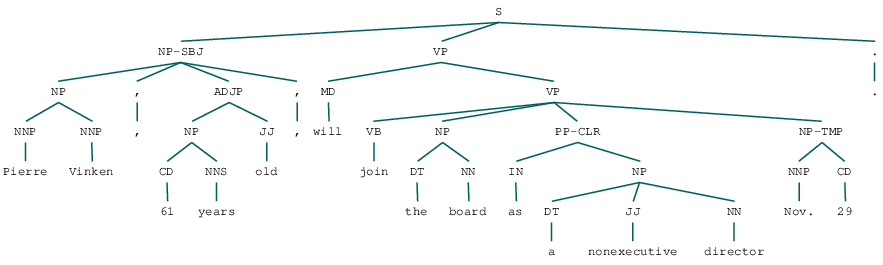

In [96]:
parsed_sents[0]

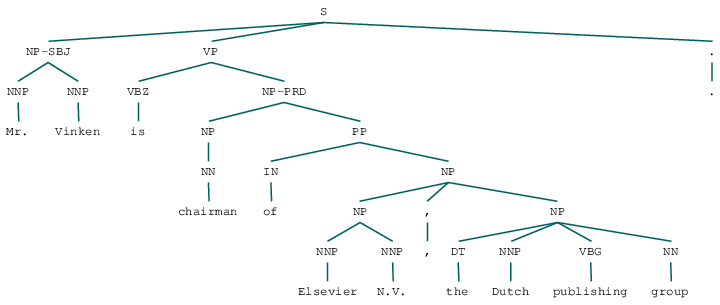

In [97]:
parsed_sents[1]

In [101]:
with open(raw_filepaths[0]) as fp:
    print(fp.read())

.START 

Pierre Vinken, 61 years old, will join the board as a nonexecutive director Nov. 29.
Mr. Vinken is chairman of Elsevier N.V., the Dutch publishing group. 




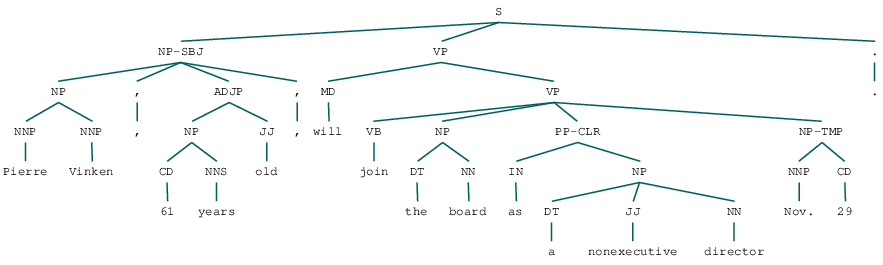

In [104]:
s0 = parsed_sents[0]
s0

In [106]:
' '.join(s0.leaves())

u'Pierre Vinken , 61 years old , will join the board as a nonexecutive director Nov. 29 .'

In [107]:
' '.join(parsed_sents[1].leaves())

u'Mr. Vinken is chairman of Elsevier N.V. , the Dutch publishing group .'

In [121]:
re.sub(' (\,|:|\.|!|\?)', r'\1', '')

'foo bar, baz, or, more important: a hammer! Or not?'

In [155]:
def tree2string(tree):
    """convert an nltk tree (that contains one sentence) into a string.
    
    """
    return ' '.join(tree.leaves())

# find non-alphanumeric tokens used in WSJ

In [122]:
# ([u'!', u'`', u'#', u'%', u'$', u"'", u'&', u'*', u'-', u',', u'.', u'@', u';', u':', u'=', u'?'],)

2338

In [10]:
sent_trees = []

for mrg_filepath in mrg_filepaths:
    mrg_path, mrg_filename = os.path.split(mrg_filepath)
    parsed_doc = nltk.corpus.BracketParseCorpusReader(mrg_path, [mrg_filename])
    sent_trees.extend([s for s in parsed_doc.parsed_sents()])

In [11]:
tree2string(non_word_tokens['`'][1])

NameError: name 'tree2string' is not defined

In [124]:
len(sent_trees)

147624

In [13]:
from collections import defaultdict
non_word_tokens = defaultdict(list)

for tree in sent_trees:
    for leaf in tree.leaves()[:-1]:  # ignore sentence endings
        if len(leaf) == 1:
            if re.match('\W', leaf):
                non_word_tokens[leaf].append(tree)

In [14]:
print(non_word_tokens.keys(), )

([u'!', u'`', u'#', u'%', u'$', u"'", u'&', u'*', u'-', u',', u'.', u'@', u';', u':', u'=', u'?'],)


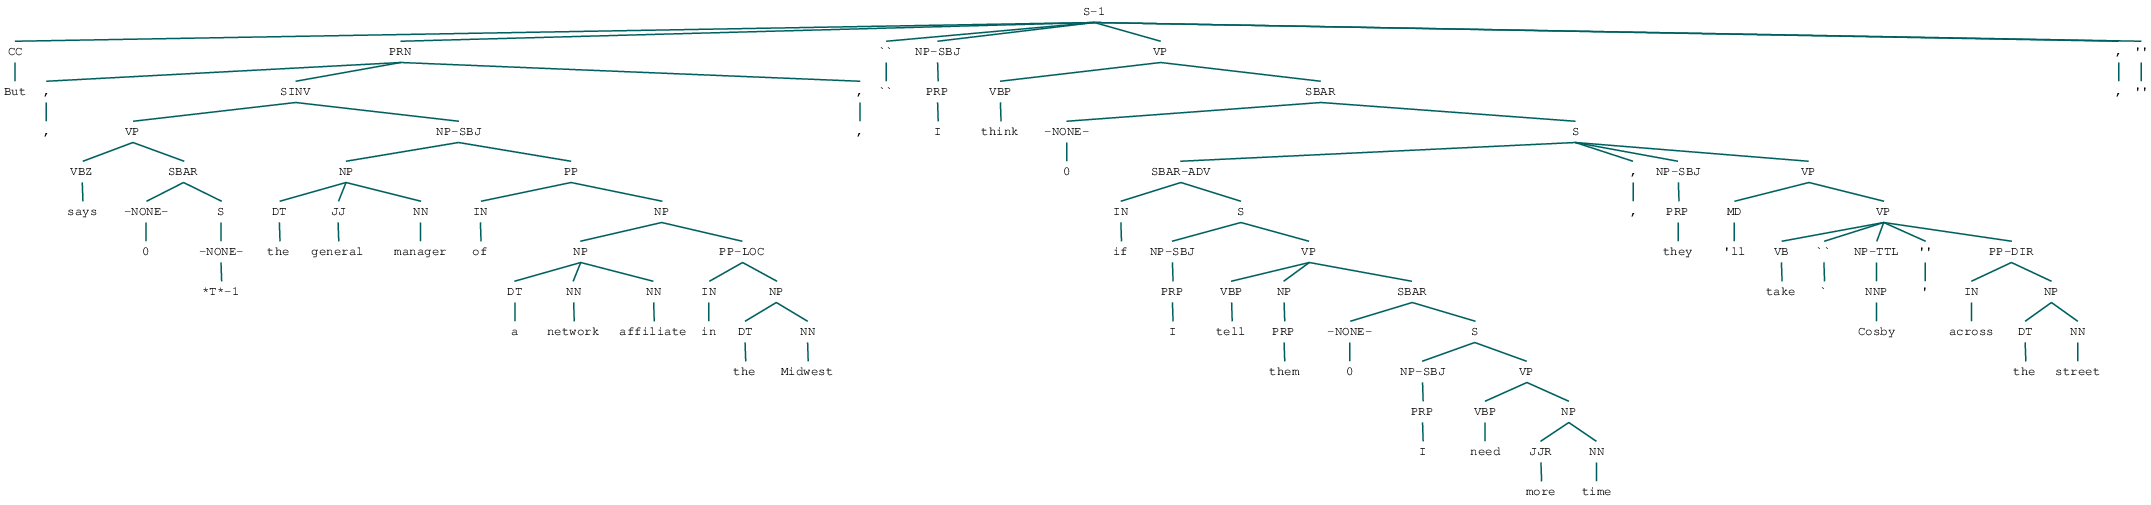

In [27]:
non_word_tokens['`'][2]

In [20]:
PTB_BRACKET_ESCAPE = {'(': r'-LRB-',
                       ')': r'-RRB-',
                       '[': r'-LSB-',
                       ']': r'-RSB-',
                       '{': r'-LCB-',
                       '}': r'-RCB-'}
PTB_BRACKET_UNESCAPE = {val:key for (key, val)
                                in PTB_BRACKET_ESCAPE.items()}

def get_nodelabel(node):
    if isinstance(node, nltk.tree.Tree):
        return node.label()
    elif isinstance(node, unicode):
        return node.encode('utf-8')
    else:
        raise ValueError("Unexpected node type: {0}, {1}".format(type(node), node))

def parse_sentencetree(tree):
    for subtree in tree:
        node_label = get_nodelabel(subtree)
        # unescape the node label, if necessary
        node_label = PTB_BRACKET_UNESCAPE.get(node_label, node_label)
        
        if node_label == '-NONE-':  # ignore tokens annotated for traces
            continue

        if isinstance(subtree, unicode):  # subtree is a token
            # we'll have to modify the parent node of a token, since
            # in NLTK Trees, even a leaf node (with its POS tag) is
            # represented as a Tree (an iterator over a single unicode
            # string), e.g. ``Tree('NNS', ['prices'])``
            pos_tag = self.node[parent_node_id]['label']
            token_attrs = {
                'label': node_label, self.ns+':token': node_label,
                self.ns+':pos': pos_tag}
            self.node[parent_node_id].update(token_attrs)
            self.tokens.append(parent_node_id)

        if isinstance(subtree, nltk.tree.Tree):
            self._parse_sentencetree(subtree, parent_node_id=self._node_id)


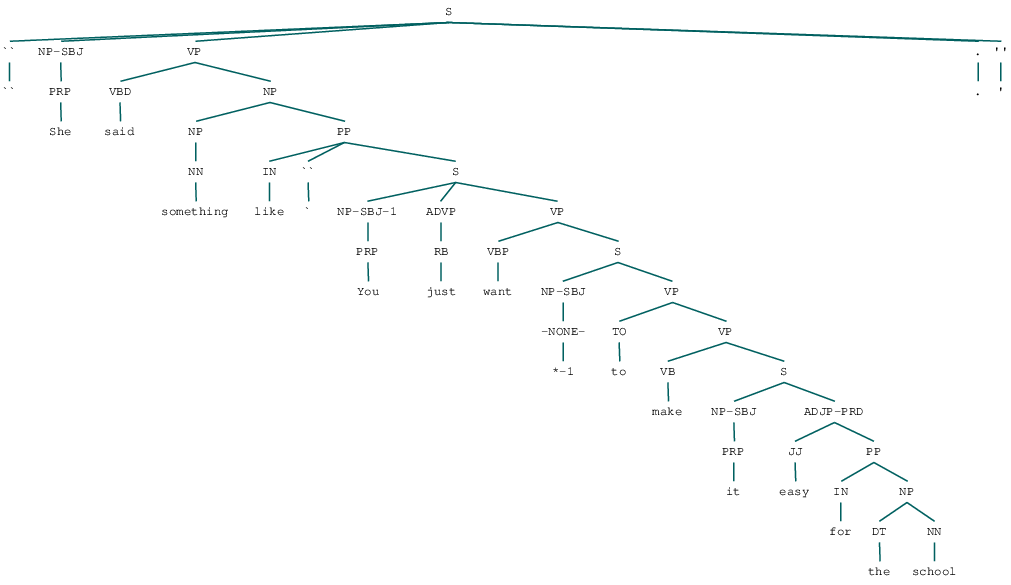

In [21]:
ex1 = non_word_tokens['`'][1]
ex1

In [22]:
ex1.leaf_treeposition(5)

(2, 1, 1, 1, 0)

In [23]:
ex1[(2, 1, 1, 1)]

In [24]:
def get_parent_treepos(treepos):
    """Given a treeposition, return the treeposition of its parent."""
    if treepos == ():  # this is the root node
        return None
    return treepos[:-1]

def tree2string_notrace(tree):
    mrg_tokens = tree.leaves()
    raw_tokens = []
    for i, tok in enumerate(mrg_tokens):
        leaf_treepos = tree.leaf_treeposition(i)
        parent_treepos = get_parent_treepos(leaf_treepos)
        if parent_treepos:
            parent_node = tree[parent_treepos]
            if get_nodelabel(parent_node) == '-NONE-':
                continue

        raw_tok = PTB_BRACKET_UNESCAPE.get(tok, tok)
        raw_tokens.append(raw_tok)
    return raw_tokens

In [25]:
tree2string_notrace(ex1)

[u'``',
 u'She',
 u'said',
 u'something',
 u'like',
 u'`',
 u'You',
 u'just',
 u'want',
 u'to',
 u'make',
 u'it',
 u'easy',
 u'for',
 u'the',
 u'school',
 u'.',
 u"'"]

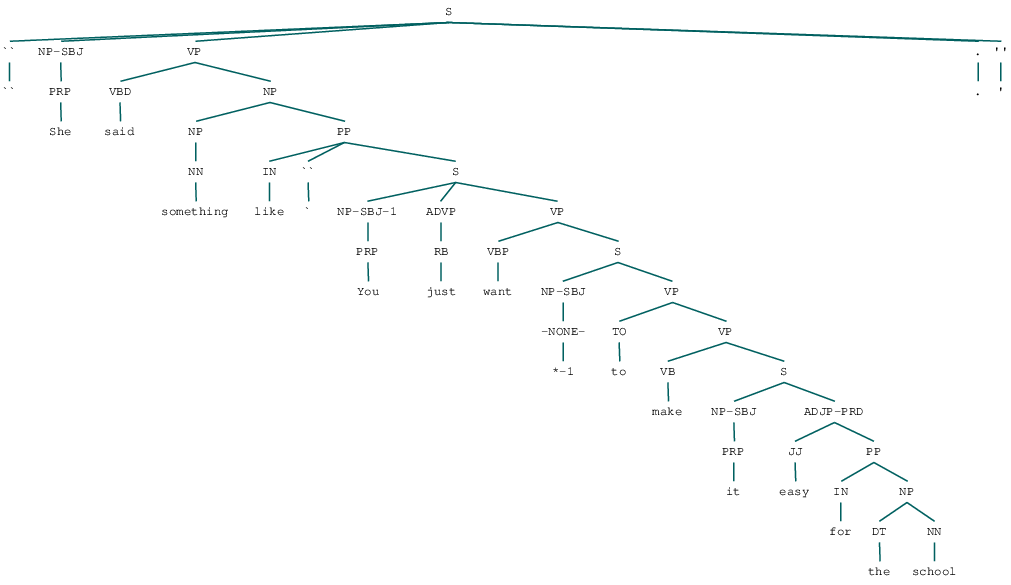

In [26]:
ex1

Automatic pdb calling has been turned ON


[u"'"]